In [1]:
import jax.numpy as jnp
import bayes3d as b
import os
import jax
import functools
from jax.scipy.special import logsumexp
from functools import partial
from tqdm import tqdm
import matplotlib.pyplot as plt
import bayes3d.genjax
import genjax
import pathlib

In [2]:
intrinsics = b.Intrinsics(
    height=100,
    width=100,
    fx=200.0, fy=200.0,
    cx=50.0, cy=50.0,
    near=0.0001, far=5.0
)

In [3]:
FILTER_SIZE = 3


@functools.partial(
    jnp.vectorize,
    signature='(m)->()',
    excluded=(0,2,),
)
def compute_score_vectorize(observed_xyz, latent_filter_xyz, variance):
    latent_filter_xyz

    
@functools.partial(
    jnp.vectorize,
    signature='(m)->(j,j)',
    excluded=(1,2,3,),
)
def convolutional_filter_vectorize(
    ij,
    observed_xyz: jnp.ndarray,
    rendered_xyz_padded: jnp.ndarray,
    variance,
):
    latent_filter_xyz = jax.lax.dynamic_slice(
        rendered_xyz_padded,
        (ij[0], ij[1], 0),
        (2*FILTER_SIZE + 1, 2*FILTER_SIZE + 1, 3)
    )
    scores = compute_score_vectorize(observed_xyz, latent_filter_xyz, variance)
    return scores

def likelihood(observed_xyz, rendered_xyz, variance):
    rendered_xyz_padded = jax.lax.pad(rendered_xyz,  intrinsics.far, ((FILTER_SIZE,FILTER_SIZE,0,),(FILTER_SIZE,FILTER_SIZE,0,),(0,0,0,)))
    jj, ii = jnp.meshgrid(jnp.arange(observed_xyz.shape[1]), jnp.arange(observed_xyz.shape[0]))
    indices = jnp.stack([ii,jj],axis=-1)

    log_probabilities = convolutional_filter_vectorize(
        indices, observed_xyz,
        rendered_xyz_padded,
        focal_length,
    )
    return log_probabilities.min(-1).min(-1)

In [50]:
center_1 = jnp.array([1.0, 1.0, 1.0])
center_2 = center_1
print(compute_score(center_1, center_2, 200.0))

center_1 = jnp.array([1.0, 1.0, 1.0])
center_2 = jnp.array([0.1, 0.1, 1.0])
print(compute_score(center_1, center_2, 200.0))

5.2086762e-15
1.0127446e-09


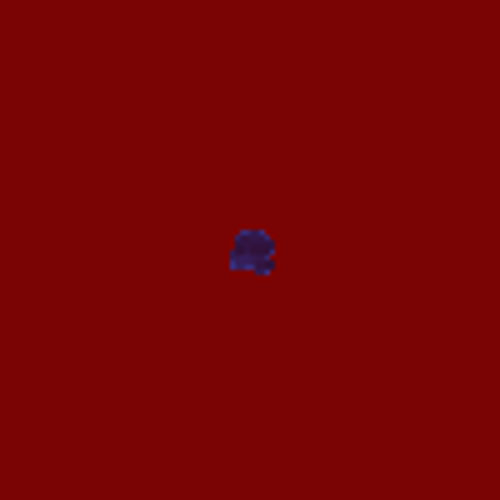

In [3]:
cloud = (jax.random.uniform(jax.random.PRNGKey(10), shape=(100,3)) - 0.5) * 0.1
def render_img(pose):
    img = b.render_point_cloud(b.apply_transform(cloud, pose), intrinsics)
    return b.unproject_depth(img[:,:,2], intrinsics)
pose1 = b.transform_from_pos(jnp.array([0.0, 0.0, 3.0]))
pose2 = b.transform_from_pos(jnp.array([0.0, 10.0, 3.0]))
img1 = render_img(pose1)
img2 = render_img(pose2)
focal_length = intrinsics.fx
b.viz.scale_image(b.get_depth_image(img1[...,2]),5.0)

9.2103405 9.2103405
3.7404403e-05


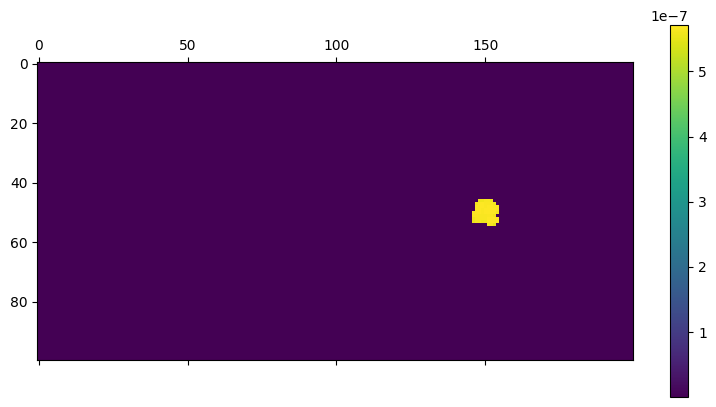

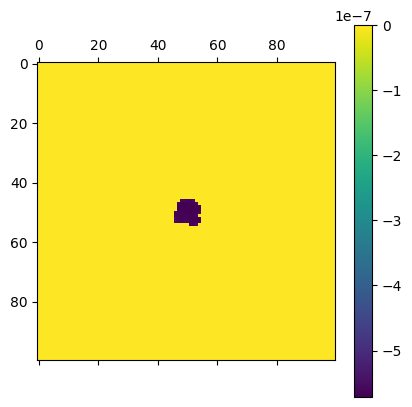

In [43]:
likelihoods1 = likelihood(img1, img1, 200.0) 
likelihoods2 = likelihood(img1, img2, 200.0)
print(logsumexp(likelihoods1), logsumexp(likelihoods2))
diff = likelihoods1 - likelihoods2
print(jnp.abs(diff).sum())
plt.matshow(jnp.hstack([likelihoods1, likelihoods2]))
plt.colorbar()

plt.matshow(diff)
plt.colorbar()

In [44]:
i,j = jnp.unravel_index(diff.argmax(), diff.shape)
print(img1[i,j])
print(img2[i,j])
print(likelihoods1[i,j])
print(likelihoods2[i,j])

[-1.25 -1.25  5.  ]
[-1.25 -1.25  5.  ]
8.1382165e-11
8.1382165e-11


In [45]:
print(convolutional_filter_vectorize(jnp.array([[i,j]]), img1, img1, 200.0).sum())

0.0010029055


In [46]:
likelihoods1[i,j]

Array(8.1382165e-11, dtype=float32)

In [47]:
print(likelihoods1[i,j])
print(likelihoods2[i,j])

8.1382165e-11
8.1382165e-11


3.1502765e-07 3.1502765e-07


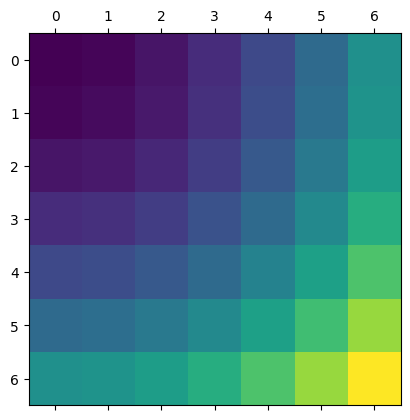

In [48]:
filter1 = convolutional_filter(jnp.array([i,j]), img1, img1, 200.0)
filter2 = convolutional_filter(jnp.array([i,j]), img1, img2, 200.0)

print(filter1.sum(), filter2.sum())
plt.matshow(filter1)

In [58]:
print(filter1.sum(), filter2.sum())

0.00601366 0.0002296514


In [52]:
filter1[3,3]

Array(0.00019132, dtype=float32)

In [53]:
filter2[3,3]

Array(3.2629362e-06, dtype=float32)

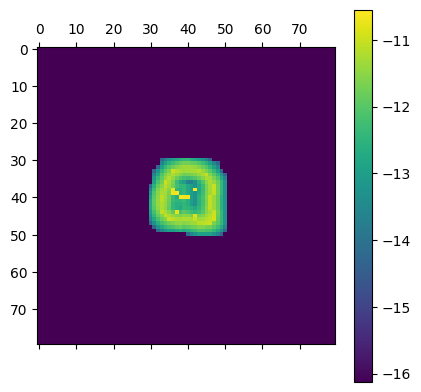

In [167]:
scores = likelihood(img1, img1, 200.0)
plt.matshow(scores[10:-10,10:-10])
plt.colorbar()

In [168]:
print(logsumexp(likelihood(img1, img1, 200.0)))
print(logsumexp(likelihood(img1, img2, 200.0)))

11.222198
11.222198


In [169]:
likelihoods1 = likelihood(img1, img1, 200.0) 
likelihoods2 = likelihood(img1, img2, 200.0)
diff = likelihoods1 - likelihoods2
print(jnp.abs(diff).sum())

1128.5712


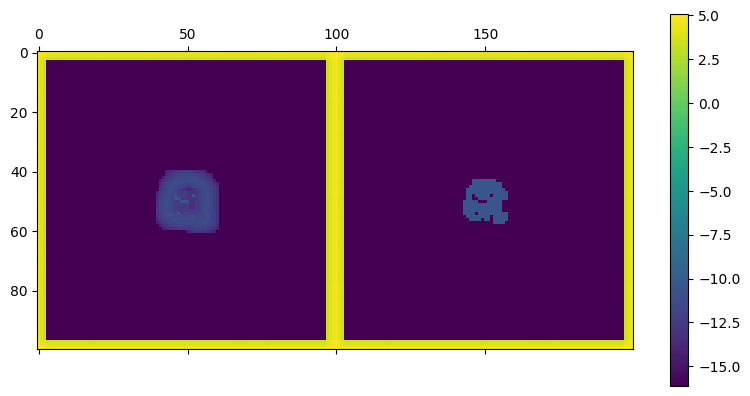

In [170]:
plt.matshow(jnp.hstack([likelihoods1, likelihoods2]))
plt.colorbar()

In [124]:
diff = 0